Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [415]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Josip\PycharmProjects\pythonProject\venv\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['poly', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [416]:
import numpy as np


def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [417]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [418]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

1.0
1.0


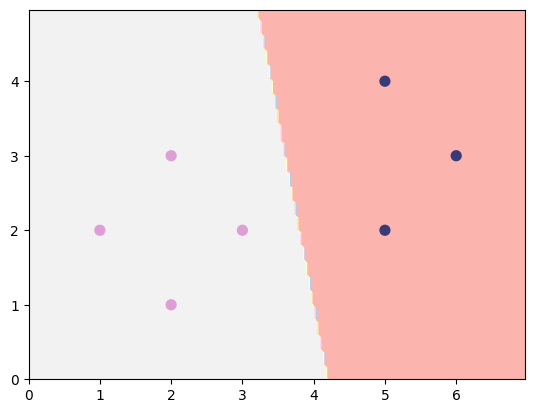

In [419]:
# Vaš kôd ovdje
clf = RidgeClassifier(alpha=0).fit(seven_X, seven_y)
print(clf.score(seven_X, seven_y))
print(accuracy_score(seven_y, clf.predict(seven_X)))
plot_2d_clf_problem(seven_X, seven_y, h=clf.predict)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

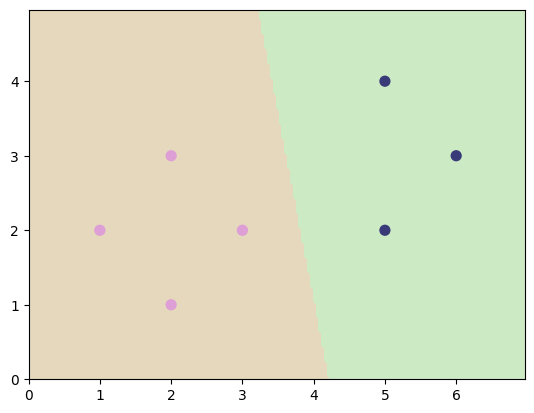

In [391]:
# Vaš kôd ovdje

model = LinearRegression().fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, h=lambda x : model.predict(x) >= 0.5)


**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [392]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

0.875
0.875


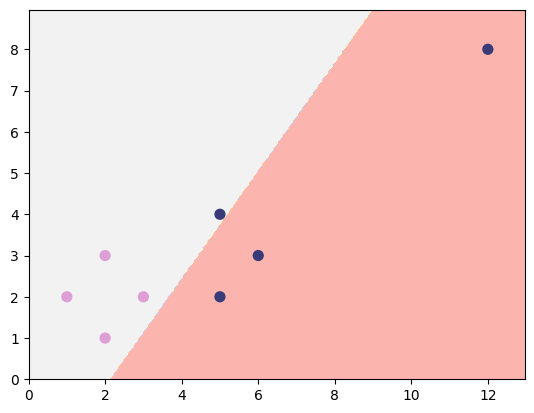

In [393]:
# Vaš kôd ovdje
clf = RidgeClassifier(alpha=0).fit(outlier_X, outlier_y)
print(clf.score(outlier_X, outlier_y))
print(accuracy_score(outlier_y, clf.predict(outlier_X)))
plot_2d_clf_problem(outlier_X, outlier_y, h=clf.predict)


**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [394]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

0.875
0.875


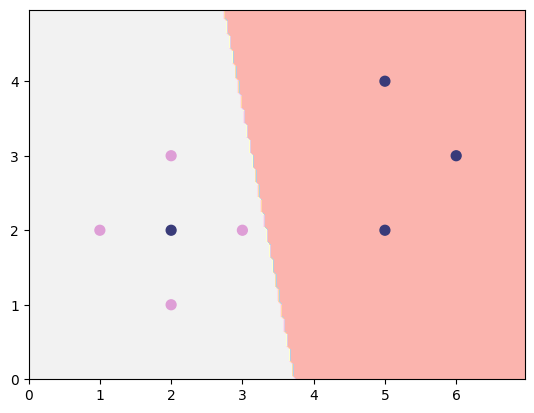

In [395]:
# Vaš kôd ovdje
clf = RidgeClassifier(alpha=0).fit(unsep_X, unsep_y)
print(clf.score(unsep_X, unsep_y))
print(accuracy_score(unsep_y, clf.predict(unsep_X)))
plot_2d_clf_problem(unsep_X, unsep_y, h=clf.predict)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

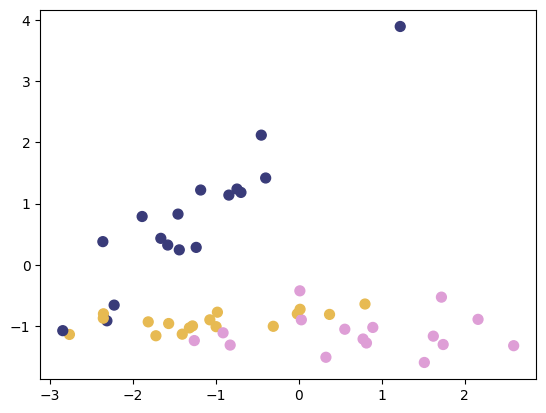

In [396]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X, y = make_classification(
    n_samples=50,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=3
)
plot_2d_clf_problem(X, y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

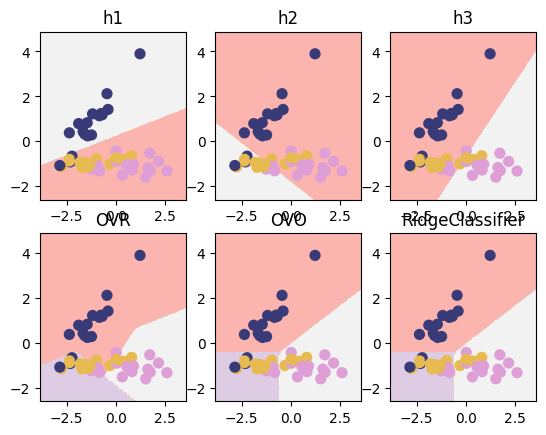

In [397]:
# Vaš kôd ovdje

plt.subplot(2,3,1)
plt.title("h1")
h1 = RidgeClassifier(alpha=0).fit(X, np.array([1 if i==0 else 0 for i in y]))


plot_2d_clf_problem(X,y, h=lambda x :h1.predict(x))

plt.subplot(2,3,2)
plt.title("h2")
h2 = RidgeClassifier(alpha=0).fit(X, np.array([1 if i==1 else 0 for i in y]))
plot_2d_clf_problem(X,y, h=lambda x :h2.predict(x))

plt.subplot(2,3,3)
plt.title("h3")
h3 = RidgeClassifier(alpha=0).fit(X, np.array([1 if i==2 else 0 for i in y]))
plot_2d_clf_problem(X,y, h=lambda x :h3.predict(x))

def predict(x):

 rez1=np.array([h1.predict(x),h2.predict(x),h3.predict(x)])

 
 return np.argmax(rez1,axis=0)

def predict2(x):

 rez1=np.array([h1.decision_function(x),h2.decision_function(x),h3.decision_function(x)])
 
 
 return np.argmax(rez1,axis=0)
plt.subplot(2,3,4)
plt.title("OVR")
plot_2d_clf_problem(X,y,h=lambda x :predict(x))

plt.subplot(2,3,5)
plt.title("OVO")
plot_2d_clf_problem(X,y,h=lambda x :predict2(x))

plt.subplot(2,3,6)
plt.title("RidgeClassifier")
clf =RidgeClassifier(alpha=0).fit(X, y)
plot_2d_clf_problem(X,y, h=lambda x :clf.predict(x))

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

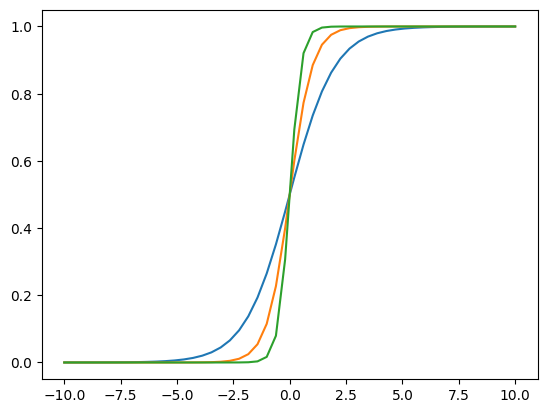

In [399]:
# Vaš kôd ovdje
import math

sigm = lambda x,alpha : (1/(1+math.exp(-alpha*x)))
polje= np.linspace(-10, 10, 50)

for i in [1,2,4]:
    poljey=np.array([])
    for j in polje:
        poljey=np.append(poljey,sigm(j,i))
    plt.plot(polje,poljey)


**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [400]:
from numpy import linalg
sigm2 = lambda x : 1/(1+math.exp(-x))
def lr_h(x,w):
    rez=np.array([])
    fx=np.array([np.append([1],xi) for xi in x])
    for i in fx:
        rez=np.append(rez,sigm2(np.dot(i.T,w)))
    return rez
    


def cross_entropy_error(X,y,w):
    sum=0.0
    for i in range(0,len(y)):
        sum=sum+(-y[i]*math.log(sigm2(np.dot(X[i],w.T)))-(1-y[i])*(math.log(1-sigm2(np.dot(X[i],w.T)))))
    return sum/len(y)
        



def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    
    # Vaš kôd ovdje
    N=len(y)

    fX=np.array([np.append([1],xi) for xi in X])
   
    w= np.full(shape=len(fX[0]), fill_value=0.0)
    tr=np.array([w])
   
    for e in range(0,max_iter):
        
        if cross_entropy_error(fX,y,w)<epsilon:
            break
        
        dw1=np.full(shape=len(fX[0]), fill_value=0.0)
        for i in range(0,N):
            h=sigm2(np.dot(w.T,fX[i]))
            
            dw1=dw1-(h-y[i])*fX[i]
            
        
        w[0]=w[0]+eta*dw1[0]
        w[1:]=w[1:]*(1-eta*alpha)+eta*dw1[1:]
        tr=np.append(tr,np.array([w]),axis=0)
   
    if trace:
        return w,tr
    return w


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [401]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

0.07751718252492557


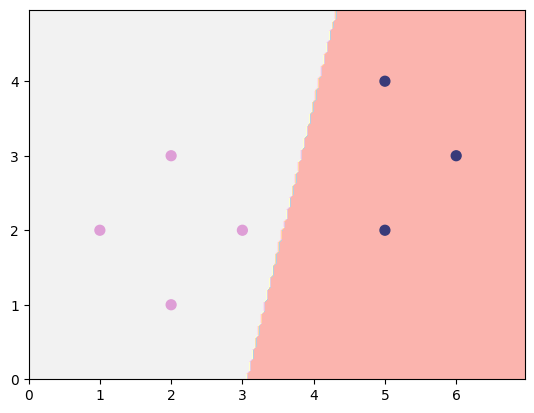

In [438]:
# Vaš kôd ovdje
w1=lr_train(seven_X,seven_y)
fseven_x=np.array([np.append([1],xi) for xi in seven_X])
def funkcija(x):
  #  print(lr_h(x,w1))
    n=np.array([1 if i>=0.5 else 0 for i in lr_h(x,w1)])
    return  n
plot_2d_clf_problem(seven_X,seven_y, h=lambda x :funkcija(x))
print((cross_entropy_error(fseven_x,seven_y,w1)))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [428]:
from sklearn.metrics import zero_one_loss

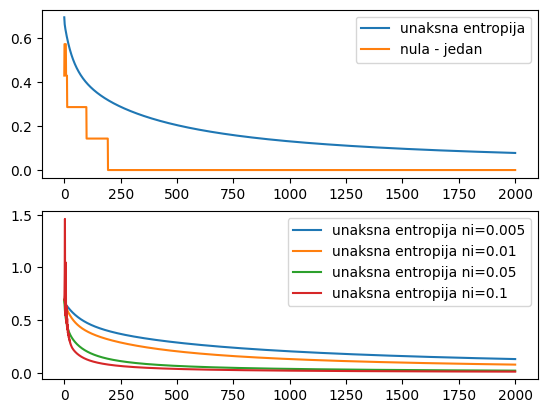

In [429]:
# Vaš kôd ovdje
w1,wtr=lr_train(seven_X,seven_y,trace=True)
fseven_x=np.array([np.append([1],xi) for xi in seven_X])
j=range(0,len(wtr))
en=np.array([])
zeroloss=np.array([])
for i in j:
    en=np.append(en,cross_entropy_error(fseven_x,seven_y,wtr[i]))
    polje=lr_h(seven_X,wtr[i])
    polje=np.array([1 if z>=0.5 else 0 for z in polje])
    zeroloss=np.append(zeroloss,zero_one_loss(polje,seven_y))
plt.subplot(2,1,1)
plt.plot(j,en,label="unaksna entropija")
plt.plot(j,zeroloss,label="nula - jedan")
plt.legend(loc="best")    
plt.subplot(2,1,2)
for p in [0.005,0.01,0.05,0.1]:
    w1,wtr=lr_train(seven_X,seven_y,trace=True,eta=p)
    j=range(0,len(wtr))
    an=np.array([])
    for i in j:
      an=np.append(an,cross_entropy_error(fseven_x,seven_y,wtr[i]))
    s="unaksna entropija ni="+str(p)
    plt.plot(j,an,label=s)
plt.legend(loc="best")  


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

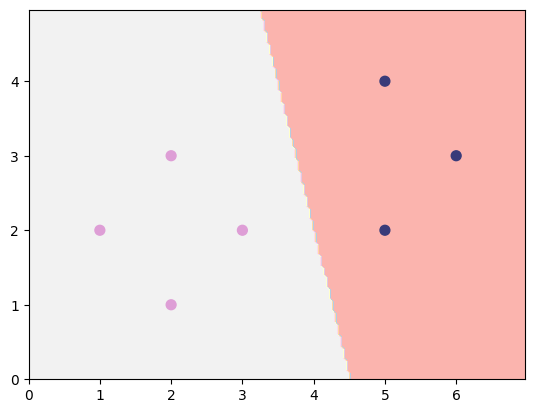

In [430]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
clf = LogisticRegression().fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X,seven_y, h=lambda x :clf.predict(x))

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [406]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

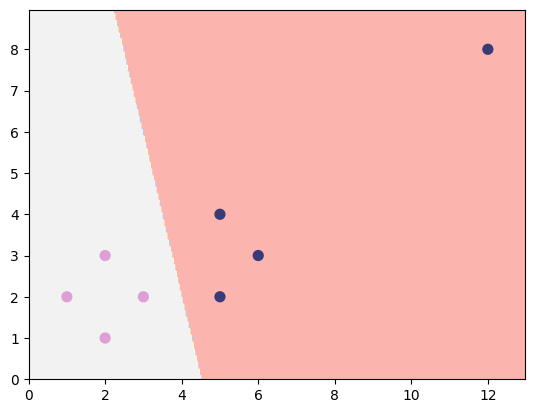

In [407]:
# Vaš kôd ovdje
clf = LogisticRegression().fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X,outlier_y, h=lambda x :clf.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

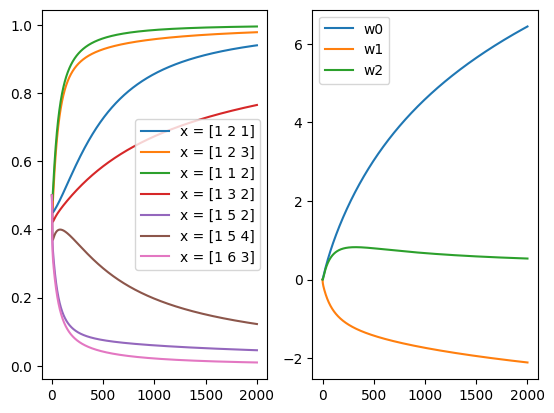

In [437]:
# Vaš kôd ovdje
w1,wtr=lr_train(seven_X,seven_y,trace=True)
fseven_x=np.array([np.append([1],xi) for xi in seven_X])
plt.subplot(1,2,1)
for i in fseven_x:
  pol=np.array([])
  for j in range(0,len(wtr)):
       pol= np.append(pol,sigm2(np.dot(i.T,wtr[j])))
  plt.plot(range(0,len(wtr)), pol, label="x = "+str(i))
plt.legend(loc="best")
plt.subplot(1,2,2)

t=range(0,len(wtr[:,0]))
plt.plot(t,wtr[:,0],label="w0")
plt.plot(t,wtr[:,1],label="w1")
plt.plot(t,wtr[:,2],label="w2")
plt.legend(loc="best")

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [431]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

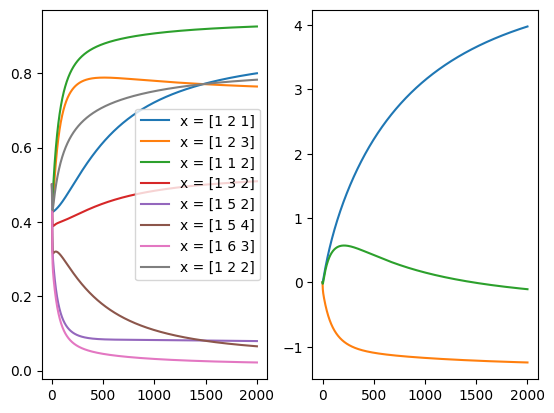

In [432]:
# Vaš kôd ovdje
w1,wtr=lr_train(unsep_X,unsep_y,trace=True)
funsep_x=np.array([np.append([1],xi) for xi in unsep_X])
plt.subplot(1,2,1)
for i in funsep_x:
  pol=np.array([])
  for j in range(0,len(wtr)):
       pol= np.append(pol,sigm2(np.dot(i.T,wtr[j])))
  plt.plot(range(0,len(wtr)), pol, label="x = "+str(i))
plt.legend(loc="best")
plt.subplot(1,2,2)

t=range(0,len(wtr[:,0]))
plt.plot(t,wtr[:,0])
plt.plot(t,wtr[:,1])
plt.plot(t,wtr[:,2])

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [433]:
from numpy.linalg import norm

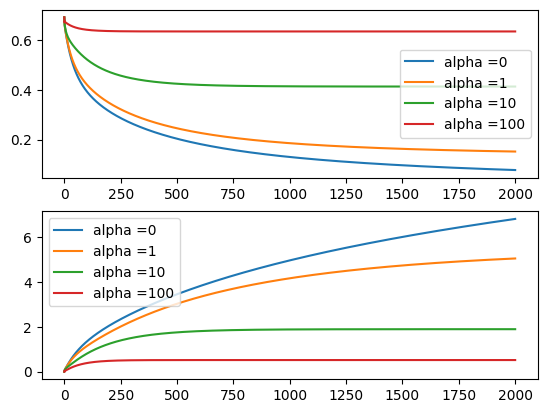

In [434]:
# Vaš kôd ovdje
#cross_entropy_error(X,y,w)
w1,wtr=lr_train(seven_X,seven_y,trace=True)
fseven_x=np.array([np.append([1],xi) for xi in seven_X])
plt.subplot(2,1,1)
for a in [0,1,10,100]:
  w1,wtr=lr_train(seven_X,seven_y,trace=True,alpha=a)
 
  pol=np.array([])
  for j in range(0,len(wtr)):
       pol= np.append(pol,cross_entropy_error(fseven_x,seven_y,wtr[j]))
  l="alpha ="+str(a)
  plt.plot(range(0,len(wtr)), pol, label=l)
plt.legend(loc="best")
plt.subplot(2,1,2)
for a in [0,1,10,100]:
  w1,wtr=lr_train(seven_X,seven_y,trace=True,alpha=a)
 
  pol=np.array([])
  for j in range(0,len(wtr)):
       pol= np.append(pol,linalg.norm(wtr[j],2))
  l="alpha ="+str(a)
  plt.plot(range(0,len(wtr)), pol, label=l)
plt.legend(loc="best")

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [435]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

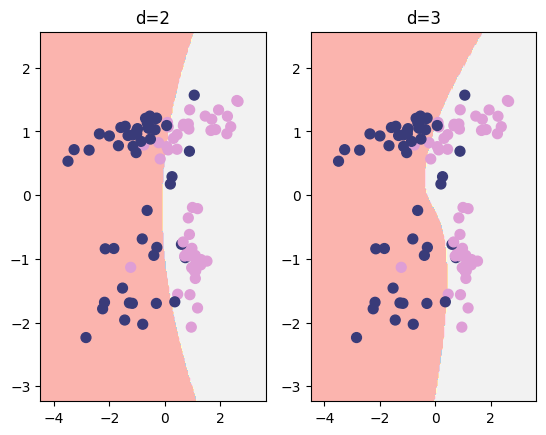

In [436]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=2,
    n_classes=2
)

poly=PolynomialFeatures(2)
X2=poly.fit_transform(X)
model=LogisticRegression().fit(X2, y)
plt.subplot(1,2,1)

plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x)))
plt.title("d="+str(2))
poly=PolynomialFeatures(3)
X3=poly.fit_transform(X)
model2=LogisticRegression().fit(X3,y)
plt.subplot(1,2,2)
plt.title("d="+str(3))
plot_2d_clf_problem(X, y, lambda x : model2.predict(poly.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?